In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk

In [6]:
review=pd.read_csv('flipkart_reviews.csv', encoding = 'latin-1')
review.head()

,review,rating
0,It was nice produt. I like it's design a lot. ...,5
1,awesome sound....very pretty to see this nd th...,5
2,awesome sound quality. pros 7-8 hrs of battery...,4
3,I think it is such a good product not only as ...,5
4,Awsome sound powerful bass battery backup is a...,5


In [7]:
review.tail(10)

,review,rating
9926,Very good product a problem is headphone islit...,5
9927,Awsm productREAD MORE,5
9928,delivery man was awesome.READ MORE,5
9929,The box was looking like it had opened and the...,4
9930,SuperREAD MORE,4
9931,Everything of this headset is well good such a...,4
9932,Good qualityREAD MORE,5
9933,"Amazing Bass, Good sound quality, little bit h...",5
9934,Awesome just loved itREAD MORE,5
9935,Only One word (ONE OF THE BEST HEADPHONE)READ ...,5


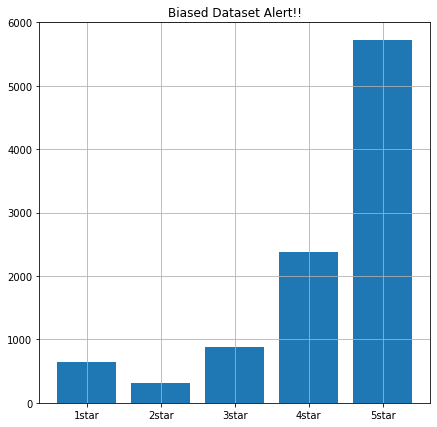

In [9]:
## plotting bar graph for 
plt.figure(figsize = (7,7))
ratings = ['1star','2star','3star', '4star', '5star']
numRatings = [len(review[review['rating'] == 1 ]),
             len(review[review['rating'] == 2 ]),
             len(review[review['rating'] == 3 ]),
             len(review[review['rating'] == 4 ]),
             len(review[review['rating'] == 5 ])
             ]
plt.title('Biased Dataset Alert!!')
plt.grid(True)
plt.bar(ratings, numRatings)
plt.show()

In [10]:
review['rating'].value_counts()

5    5715
4    2382
3     884
1     640
2     315
Name: rating, dtype: int64

In [11]:
review.isnull().mean()

review    0.0
rating    0.0
dtype: float64

In [20]:
import re
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 

In [25]:
def WordCloudForRating (review, rating):
    df =  (review[review['rating'] == rating]['review'])
    corpus = ''
    
    for mem in df:
        corpus += mem
    
    corpus = re.sub('READ MORE', '', corpus)
    wordcloud = WordCloud(width = 800, height = 800,background_color='yellow',stopwords = stopwords,  min_font_size = 10).generate(corpus)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.rcParams.update({'font.size': 25})
    plt.axis("off") 
    plt.title('Word Cloud:  ' + str(rating) + ' star reviews')
    plt.tight_layout(pad = 0) 
  
    plt.show() 

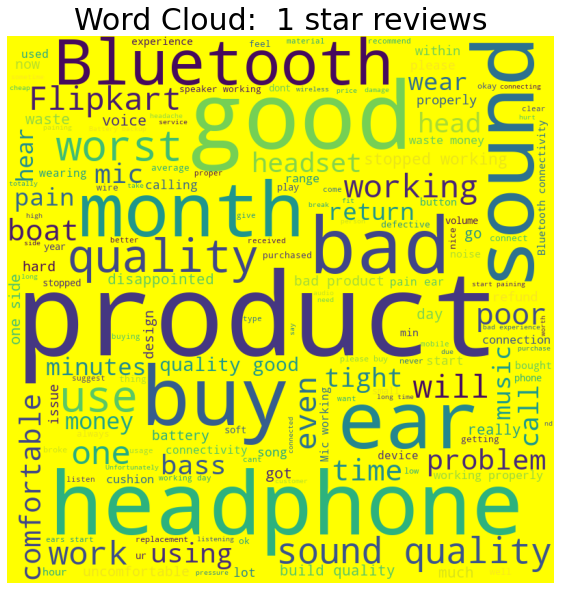

In [26]:
WordCloudForRating(review, 1)

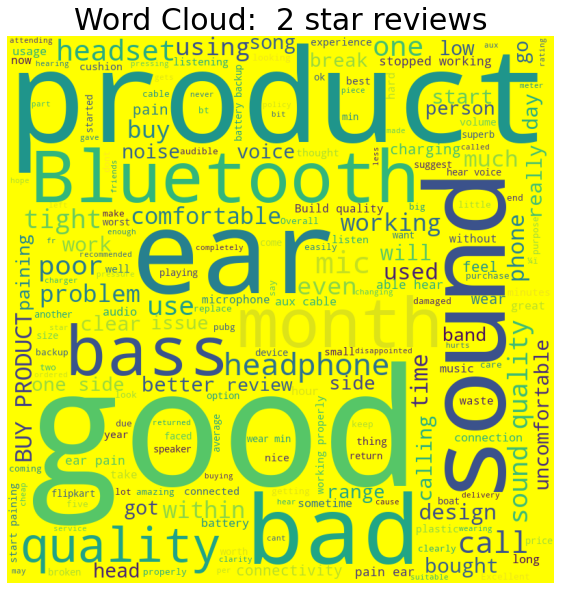

In [27]:
WordCloudForRating(review, 2)

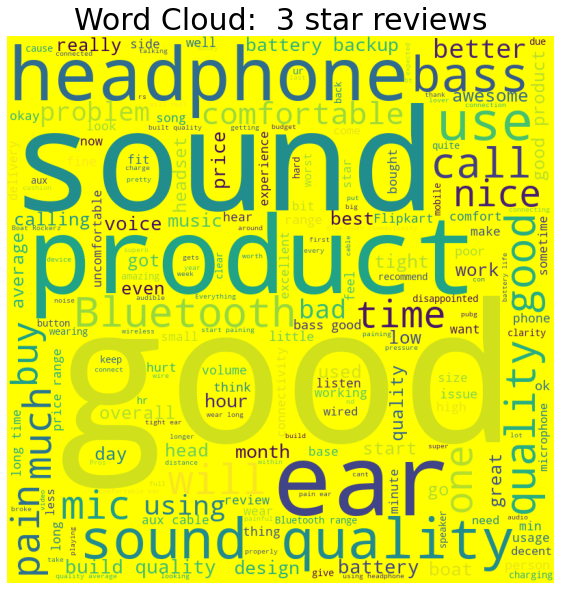

In [28]:
WordCloudForRating(review, 3)

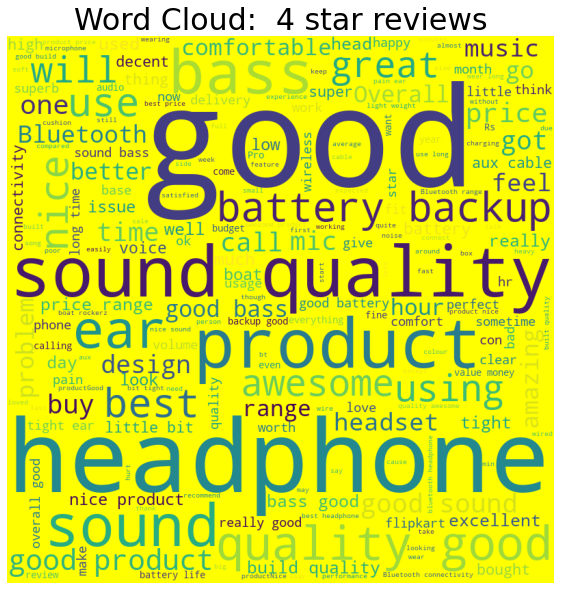

In [29]:
WordCloudForRating(review, 4)

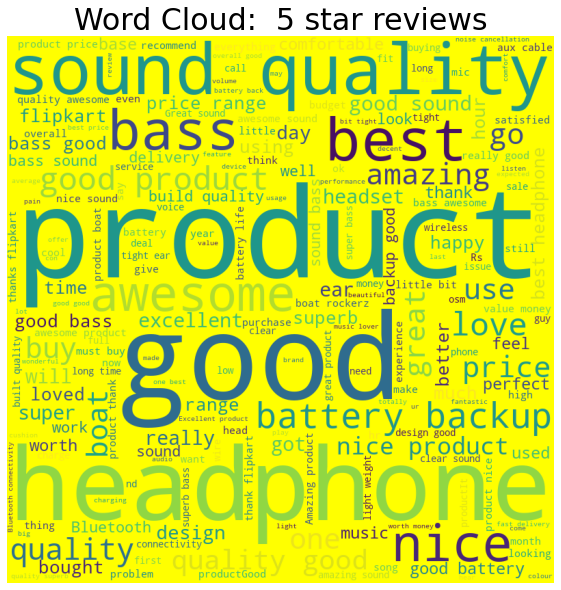

In [30]:
WordCloudForRating(review, 5)

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(review['review'],review['rating'], test_size=0.3)

In [58]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [59]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [60]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [61]:
X_train_seq[0]

[2040, 859, 10, 13, 38, 104, 1]

In [62]:
X_test_seq[0]

[26, 7, 12, 1]

In [63]:
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [64]:
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2040,
        859,   10,   13,   38,  104,    1], dtype=int32)

In [65]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [66]:
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          217760    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 227,169
Trainable params: 227,169
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [43]:
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
218/218 [==============================] - 9s 28ms/step - loss: -25.7618 - accuracy: 0.0640 - precision_m: 7631073.6170 - recall_m: 0.9960 - val_loss: -186.6134 - val_accuracy: 0.0725 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 2/10
218/218 [==============================] - 6s 26ms/step - loss: -285.2041 - accuracy: 0.0606 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: -639.8180 - val_accuracy: 0.0725 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 3/10
218/218 [==============================] - 5s 25ms/step - loss: -817.0953 - accuracy: 0.0595 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: -1356.1510 - val_accuracy: 0.0725 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 4/10
218/218 [==============================] - 6s 27ms/step - loss: -1619.4097 - accuracy: 0.0575 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: -2323.0979 - val_accuracy: 0.0725 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 5/10
218/218 [================

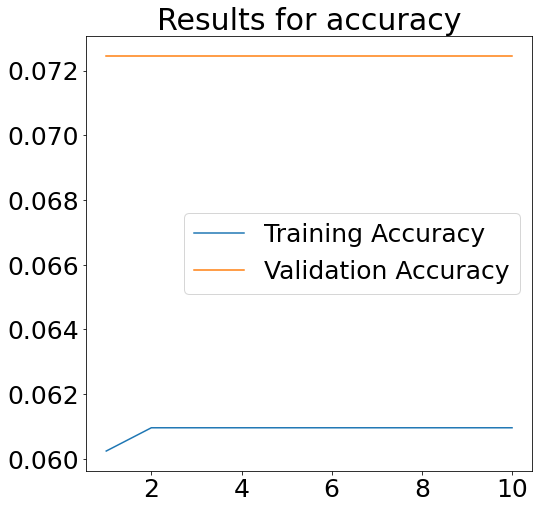

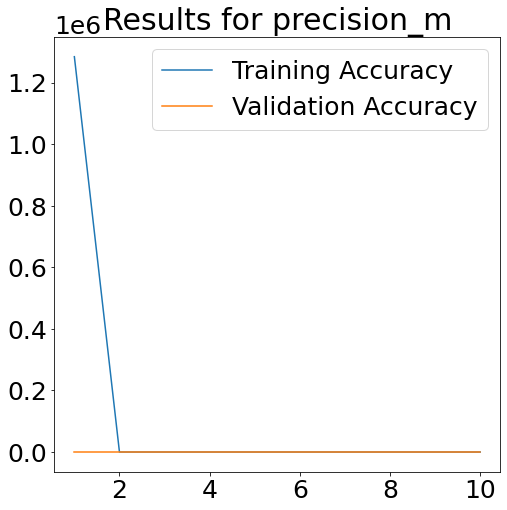

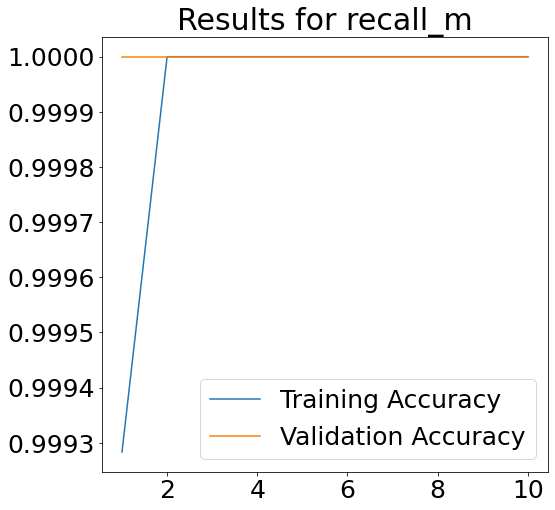

In [47]:
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8,8))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()